In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from wavegen import srrc, sine_wave
from transmitter import oversample
from receiver import quantalph, pulse_correlator
from sampling import interpolate

## 12.3 Decision Directed Timing Recovery

In [5]:
# Transmission Parameters
N = 10000 # num symbols
M = 2 # oversampling factor
alphabet = np.array([-3, -1, 1, 3]) # 4-PAM

# SRRC parameters
half_len = 50
beta = 0.3 # Roll-off for square root raised cosine
timing_offset = -0.3

# Channel
channel = np.array([1.]) 

In [6]:
# Transmitted signal
symbols = np.random.choice(alphabet, N) # 4-PAM
pulse = srrc(half_len, M, beta, timing_offset)

oversampled = oversample(symbols, M)
analog = np.convolve(oversampled, pulse)

# Receiver
received = np.convolve(analog, channel)
matched_out = np.convolve(received, srrc(half_len, M, beta, 0), 'same')

### Adaptive loop

CPU times: user 4.64 s, sys: 8.97 ms, total: 4.65 s
Wall time: 4.65 s


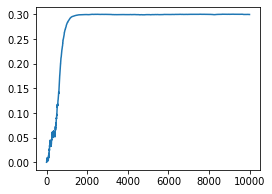

In [7]:
%%time
# Clock recovery parameters
mu = 0.01
delta = 0.1 # for derivative calculation

# Initialization
tau = 0
tau_history = [0]
sample_history = []
t_now = half_len * M
# Run loop
while t_now < len(matched_out) - half_len*M:
    sample = interpolate(matched_out, t_now+tau, half_len)
    sample_right = interpolate(matched_out, t_now + tau + delta, half_len)
    sample_left = interpolate(matched_out, t_now + tau - delta, half_len)
    deriv = (sample_right - sample_left) # The 1/(2*delta) is included in mu
    decision = quantalph(sample, alphabet)[0]
    # Updates
    tau = tau + mu * deriv * (decision - sample)
    t_now += M
    # Save history 
    sample_history.append(sample)
    tau_history.append(tau)
    
normalized_tau_history = np.array(tau_history)/M
plt.plot(normalized_tau_history);


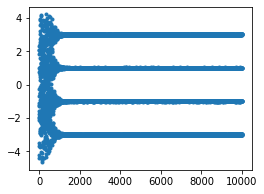

In [8]:
# Check the sampled data (soft decisions)
plt.plot(sample_history, '.');

### Error Surface

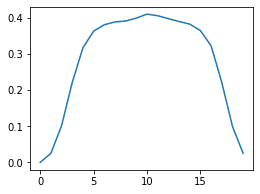

In [9]:
# Error surface
half_len = 10
beta = 0.3
M = 20
N = 10000

# Create the srrc and raised cosine pulses
pulse = srrc(half_len, M, beta)
squared_pulse = np.convolve(pulse, pulse, 'same')

# Calculate error surface
cost = np.zeros(M)
x = np.zeros(N)
for i in np.arange(M):
    shifted_pulse = squared_pulse[i::M]
    # Average over N runs
    for k in range(N):
        symbols = np.random.choice(alphabet, len(shifted_pulse)) # 4-PAM
        x[k] = np.dot(symbols, shifted_pulse)
    err = quantalph(x, alphabet) - x
    cost[i] = np.sum(err**2)/len(err)
    
plt.plot(np.arange(M), cost);